# 3.強い推論器の確率を特徴量に追加
特徴量がもともと少なめなので増やす方向で進める。

- 強い推論器の推論の確率値を追加 
- クラスタリングにおける各クラスへの距離

今回は強い推論きの確率値を加えてみる。
特にLogisticregression,SVCにおいて改善が見られたのでvotingなどで得られる確率をLR,SVCの特徴量として使う

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys, os
from pathlib import Path
# signalfuncなどのある親ディレクトリのパスを取得,これはJupyter系特有の書き方
current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../')
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

import ml_modules as mm

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from mlxtend.classifier import StackingClassifier
from scipy import interp

/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import lightgbm as lgb
import xgboost as xgb

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [7]:
df_train_data = pd.read_csv('../data/wine_train.csv')
df_train_data = pd.get_dummies(df_train_data)

In [8]:
bins = [0,5,7,10]
labels = [0,1,2]

df_train_data['quality_range']=pd.cut(x=df_train_data['quality'], bins=bins, labels=labels)

In [9]:
details = mm.rstr(df_train_data, 'quality')
details

Data shape: (5497, 15)
___________________________
Data types:
 float64    4
int64      3
object     2
dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr quality
fixed.acidity,float64,5497,104,0,0.0,"[5.8, 5.4, 7.4, 7.0, 7.9, 6.1, 5.6, 6.2, 11.9,...",1.732083,5.146521,-0.077304
volatile.acidity,float64,5497,181,0,0.0,"[0.18, 0.835, 0.61, 0.31, 0.35, 0.15, 0.66, 0....",1.480543,2.825178,-0.266449
citric.acid,float64,5497,87,0,0.0,"[0.37, 0.08, 0.01, 0.26, 0.36, 0.29, 0.0, 0.48...",0.355286,1.379355,0.080977
residual.sugar,float64,5497,303,0,0.0,"[1.1, 1.2, 2.0, 7.4, 1.6, 6.2, 2.5, 2.8, 6.9, ...",1.486139,5.006813,-0.041976
chlorides,float64,5497,204,0,0.0,"[0.036000000000000004, 0.046, 0.07400000000000...",5.637169,54.706018,-0.200778
free.sulfur.dioxide,float64,5497,128,0,0.0,"[31.0, 13.0, 28.0, 11.0, 39.0, 7.0, 29.0, 6.0,...",1.298491,9.065928,0.056353
total.sulfur.dioxide,float64,5497,275,0,0.0,"[96.0, 93.0, 38.0, 160.0, 124.0, 151.0, 15.0, ...",0.023181,-0.327189,-0.037969
density,float64,5497,964,0,0.0,"[0.9894200000000001, 0.9924, 0.997479999999999...",0.589583,7.615904,-0.313193
pH,float64,5497,108,0,0.0,"[3.16, 3.57, 3.48, 3.13, 3.25, 3.6, 3.52, 3.33...",0.396733,0.416000,0.009871
sulphates,float64,5497,109,0,0.0,"[0.48, 0.85, 0.65, 0.46, 0.44, 0.58, 0.39, 0.5...",1.881176,9.585108,0.032083


In [17]:
x = df_train_data[list(set(df_train_data.columns)-set(['type_W','type_R','quality','quality_range']))]
# y = df_train_data['quality_range']
y = df_train_data['quality']

ss = StandardScaler()
scaled_x = pd.DataFrame(columns=x.columns,data=ss.fit_transform(x))

In [64]:
filename_voting = '../model/lda_rm_multico_voting_model.pickle'
filename_GBC = '../model/logloss_pca_rm_multico_GBC_model.pickle'
filename_KNN = '../model/rm_multico_KNN_model.pickle'
with open(filename_voting, mode='rb') as fp:
    voting = pickle.load(fp)
with open(filename_GBC, mode='rb') as fp:
    gbc = pickle.load(fp)
with open(filename_KNN, mode='rb') as fp:
    knn = pickle.load(fp)
    
est_dict = {
    'voting':voting,
    'gbc': gbc,
    'knn' : knn
}

In [116]:
X_train = pd.read_csv('../data/X_train.csv', header=0, index_col=0)
y_train = pd.read_csv('../data/y_train.csv',names=('l'))
X_test = pd.read_csv('../data/X_test.csv', header=0, index_col=0)
y_test = pd.read_csv('../data/y_test.csv',names=('l'))

In [117]:
X_train.drop(['total.sulfur.dioxide','residual.sugar'], axis=1, inplace=True) # alcholと相関が強いので除外してみる
X_test.drop(['total.sulfur.dioxide','residual.sugar'], axis=1, inplace=True) # alcholと相関が強いので除外してみる

In [67]:
X_train = mm.add_predict_prob(est_dict=est_dict,df=X_train)
X_test = mm.add_predict_prob(est_dict=est_dict,df=X_test)

In [69]:
X_train.head(10)

,pH,alcohol,volatile.acidity,density,free.sulfur.dioxide,citric.acid,chlorides,fixed.acidity,sulphates,voting_prob_label0,...,gbc_prob_label4,gbc_prob_label5,gbc_prob_label6,knn_prob_label0,knn_prob_label1,knn_prob_label2,knn_prob_label3,knn_prob_label4,knn_prob_label5,knn_prob_label6
0,0.505978,1.760586,0.175455,-1.458013,-0.193486,-1.166493,-0.764287,-0.019138,0.388898,0.005941,...,0.930705,0.003137,0.000035,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.116877,-0.580347,1.478436,0.656975,-1.428266,-0.958494,0.624080,0.977297,-0.349098,0.015599,...,0.005380,0.000589,0.000024,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.194550,1.676982,-0.066960,-1.464622,0.199398,-0.126495,-0.565949,-0.555680,0.657261,0.005769,...,0.958218,0.001235,0.000009,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.179163,0.422910,-0.612393,-0.975531,-0.698623,1.052170,-0.367610,-0.172435,-0.550370,0.009437,...,0.035171,0.001896,0.000031,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.879691,1.258958,-0.188167,-0.697939,-0.586371,-0.057162,-0.707619,-0.402382,1.931982,0.006192,...,0.900387,0.005361,0.000023,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.128833,0.339306,1.569341,0.141447,-0.361865,-2.137159,0.652414,-0.095787,0.523080,0.011531,...,0.004172,0.000426,0.000017,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.194550,-1.081975,-0.127563,0.590881,0.087145,-0.403828,-0.084270,-0.249084,-0.147826,0.014179,...,0.006921,0.000737,0.000028,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,-1.175731,-0.078718,-1.036619,-1.054843,0.143272,-0.126495,-0.622617,-0.632328,-0.282007,0.005343,...,0.018027,0.000801,0.000021,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,-0.366019,1.091748,-0.491186,-1.421661,-0.389929,-0.403828,-1.047627,-0.325733,-0.416189,0.004445,...,0.084275,0.002556,0.000052,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.132265,-0.914765,-1.097223,-0.301379,-0.025107,-0.681161,-0.735953,-1.322168,-1.154185,0.009860,...,0.006532,0.001011,0.000025,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [124]:
clf = Pipeline([
    ('pca', PCA(random_state = 101)), 
#     ('lda', LDA(store_covariance=True)),
    ('clf', LogisticRegression(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
n_components= [6, 7, 8]
whiten = [True] #, False]
C =  [0.003, 0.009, 0.01]#, 0.1, 1.0, 10.0, 100.0, 1000.0]
tol = [0.001, 0.0001] # [1e-06, 5e-07, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]

param_grid =\
    [{'clf__C': C
     ,'clf__solver': ['liblinear', 'saga'] 
     ,'clf__penalty': ['l1', 'l2']
     ,'clf__tol' : tol 
     ,'clf__class_weight': [None, 'balanced']
     ,'pca__n_components' : n_components
#      ,'lda__n_components' : n_components 
},
    {'clf__C': C
     ,'clf__max_iter': [3, 9, 2, 7, 4]
     ,'clf__solver': ['newton-cg', 'sag', 'lbfgs']
     ,'clf__penalty': ['l2']
     ,'clf__tol' : tol 
     ,'clf__class_weight': [None, 'balanced'] 
#      ,'pca__n_components' : n_components
#      ,'lda__n_components' : n_components 
     
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
LR = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [ ]:
LR.fit(X_train,y_train)

Model Performance metrics:
------------------------------
Accuracy:  66.09% 
Precision: 66.07% 
Recall:    66.09% 
F1 Score:  64.88% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.66      0.71      0.68       473
           7       0.61      0.54      0.57       200
           5       0.69      0.76      0.73       351
           8       0.67      0.31      0.43        32
           4       0.67      0.11      0.18        38
           3       1.00      0.17      0.29         6
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1100
   macro avg       0.61      0.37      0.41      1100
weighted avg       0.66      0.66      0.65      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                       
                   6    7    5   8  4  3  9
Actual: 6        337   46   88   1  1  0  0
        7      

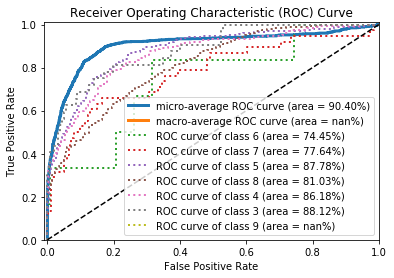

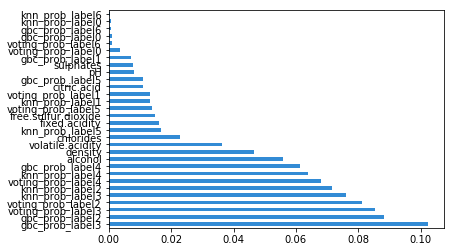

In [72]:
results = mm.get_results(LR,'LogisticRegression', X_test, y_test['l'], gs = gs,target_labels=y.unique(),target_names=[str(x) for x in y.unique()], reasume=True)

In [125]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN
LinearSVC,True,0.6609,0.729357,NaN
RF,True,0.6555,0.721854,NaN
KNeighborsClassifier,True,0.6536,0.721447,NaN
LGBM,True,0.5882,0.700122,NaN
XGBC,True,0.5909,0.684661,NaN
GradientBoostingClassifier,True,0.6000,0.670792,NaN
AdaBoostClassifier,True,0.5718,0.723659,NaN
voting,True,0.6609,0.728221,NaN


In [126]:
filename = '../model/add_prob_pca_rm_multico_lr_model.pickle'

In [127]:
with open(filename, mode='wb') as fp:
    pickle.dump(voting, fp, protocol=2)

In [128]:
results.to_csv('../data/add_prob_pca_rm_multico_results.csv')

In [77]:
clf = Pipeline([
#     ('lda', LDA(store_covariance=True)),
    ('pca', PCA(random_state = 101)),
    ('clf', DecisionTreeClassifier(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11,] # 15, 20, 25]
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None] 

param_grid =\
    [{ 'clf__class_weight': class_weight
      ,'clf__criterion': criterion
      ,'clf__splitter': splitter
      ,'clf__max_depth': max_depth
      ,'clf__min_samples_leaf': min_samples_leaf
#       ,'lda__n_components': n_components
#       ,'pca__n_components': n_components
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [78]:
DT.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.9s finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  62.27% 
Precision: 63.60% 
Recall:    62.27% 
F1 Score:  60.74% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.61      0.75      0.67       473
           7       0.73      0.42      0.54       200
           5       0.61      0.66      0.63       351
           8       0.69      0.34      0.46        32
           4       0.75      0.08      0.14        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62      1100
   macro avg       0.48      0.32      0.35      1100
weighted avg       0.64      0.62      0.61      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        356  19   97   0  0  1  0
        7         

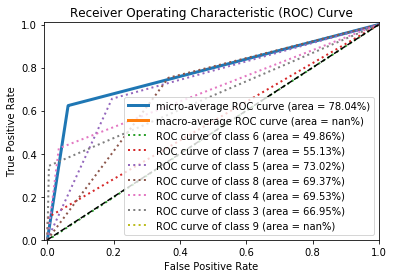

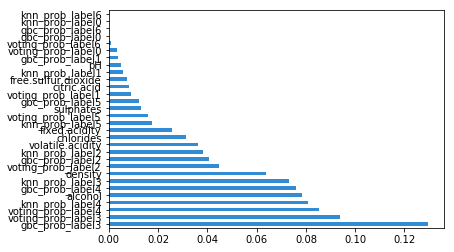

In [79]:
results = mm.get_results(DT, 'DT First', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()],target_labels=y.unique(), results=results, reasume=False)

In [80]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN


In [81]:
clf = Pipeline([
#     ('lda', LDA(store_covariance=True)), 
    ('pca', PCA(random_state = 101)),
    ('clf', SVC(random_state=101, kernel='linear', probability=True))])   

# a list of dictionaries to specify the parameters that we'd want to tune
whiten = [True] #, False]
C =  [0.003, 0.009, 0.01]#, 0.1, 1.0, 10.0, 100.0, 1000.0]
tol = [0.001, 0.0001] # [1e-06, 5e-07, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]
gamma = ['scale', 'auto']


param_grid =\
    [{'clf__C': C
     ,'clf__tol' : tol 
     ,'clf__class_weight': class_weight
#      ,'lda__n_components': n_components
#      ,'pca__n_components' : n_components
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
svc = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [82]:
svc.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.7s finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  66.09% 
Precision: 67.29% 
Recall:    66.09% 
F1 Score:  64.41% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.63      0.76      0.69       473
           7       0.68      0.47      0.56       200
           5       0.69      0.74      0.71       351
           8       0.77      0.31      0.44        32
           4       1.00      0.08      0.15        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1100
   macro avg       0.54      0.34      0.36      1100
weighted avg       0.67      0.66      0.64      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        361  29   82   1  0  0  0
        7         

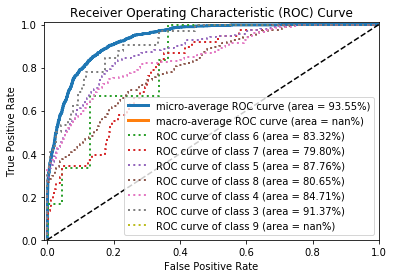

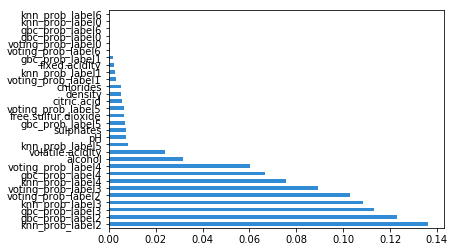

In [83]:
results = mm.get_results(svc,'LinearSVC', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()],target_labels=y.unique(),results=results, reasume=False)

In [84]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN
LinearSVC,True,0.6609,0.729357,NaN


In [85]:
clf = Pipeline([
#         ('lda', LDA(store_covariance=True)),
        ('pca', PCA(random_state = 101)),
        ('clf', RandomForestClassifier(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
SEL = X_train.columns
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]
criterion = ['gini', 'entropy']
class_weight = ['balanced', None] 
n_estimators = [155, 175]  
max_depth  = [20, None] #, 3, 4, 5, 10] # 
min_samples_split = [2, 3, 4]
min_samples_leaf = [1] #, 2 , 3]

param_grid =\
    [{ 'clf__class_weight': class_weight,
      'clf__criterion': criterion
      ,'clf__n_estimators': n_estimators      
      ,'clf__min_samples_split': min_samples_split
      ,'clf__max_depth': max_depth
#       ,'lda__n_components':n_components
#       ,'pca__n_components':n_components
#       ,'pca__whiten' : whiten
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
RF = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)), 
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [86]:
RF.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.3min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  65.55% 
Precision: 67.24% 
Recall:    65.55% 
F1 Score:  63.82% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.62      0.78      0.69       473
           7       0.70      0.45      0.55       200
           5       0.70      0.70      0.70       351
           8       0.77      0.31      0.44        32
           4       1.00      0.08      0.15        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1100
   macro avg       0.54      0.33      0.36      1100
weighted avg       0.67      0.66      0.64      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        371  25   76   1  0  0  0
        7        1

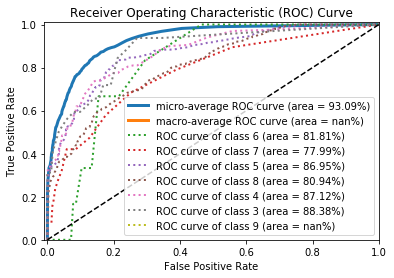

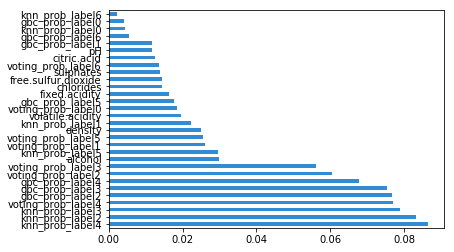

In [87]:
results = mm.get_results(RF, 'RF', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()], target_labels=y.unique(), results=results, reasume=False)

In [88]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN
LinearSVC,True,0.6609,0.729357,NaN
RF,True,0.6555,0.721854,NaN


In [89]:
clf = Pipeline([
#         ('lda', LDA(store_covariance=True)),
        ('pca', PCA(random_state = 101)),
        ('clf', KNeighborsClassifier())])

# a list of dictionaries to specify the parameters that we'd want to tune
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]

param_grid =\
    [{
     'clf__n_neighbors': [19, 20,21,22,23,24,25,26,27,28,29,30] 
     ,'clf__weights': ['distance'] 
     ,'clf__algorithm' : ['ball_tree', 'brute', 'auto',  'kd_tree', 'brute']
     ,'clf__leaf_size': [12, 11, 13]
     ,'clf__p': [1] 
#      ,'lda__n_components' : n_components
#      ,'pca__n_components' : n_components
#      ,'pca__whiten' : whiten
     }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

KNNC = Pipeline([
#         ('sel', select_fetaures(select_cols=SEL)),
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [90]:
KNNC.fit(X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.3min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

In [91]:
# file_knn = '../model/KNN.pickle'

In [92]:
# with open(file_knn, mode='wb') as fp:
#     pickle.dump(KNNC, fp, protocol=2)

Model Performance metrics:
------------------------------
Accuracy:  65.36% 
Precision: 67.02% 
Recall:    65.36% 
F1 Score:  63.49% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.62      0.77      0.69       473
           7       0.69      0.44      0.54       200
           5       0.68      0.72      0.70       351
           8       0.83      0.31      0.45        32
           4       1.00      0.05      0.10        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.65      0.65      0.65      1100
   macro avg       0.55      0.33      0.35      1100
weighted avg       0.67      0.65      0.63      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        365  25   82   1  0  0  0
        7        1

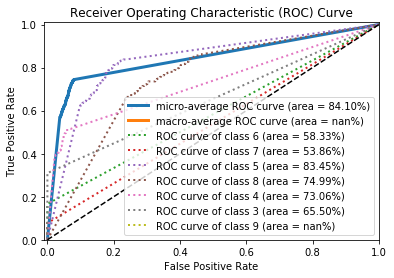

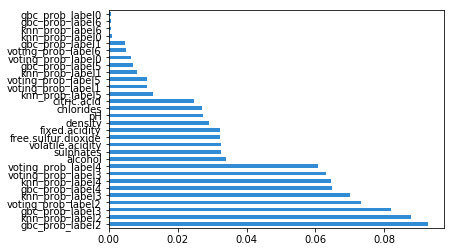

In [93]:
results = mm.get_results(KNNC, 'KNeighborsClassifier', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()],
                      target_labels=y.unique(),results=results, reasume=False)

In [94]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN
LinearSVC,True,0.6609,0.729357,NaN
RF,True,0.6555,0.721854,NaN
KNeighborsClassifier,True,0.6536,0.721447,NaN


In [95]:
clf = Pipeline([
#         ('lda', LDA(store_covariance=True)),
        ('pca', PCA(random_state = 101)),
        ('clf', lgb.LGBMClassifier(objective='multiclass',
                        num_leaves = 31,
                        learning_rate=0.1,
                        min_child_samples=10,
                        n_estimators=100))])  

# a list of dictionaries to specify the parameters that we'd want to tune
SEL = X_train.columns
whiten = [True, False]
criterion = ['gini', 'entropy']
class_weight = ['balanced', None] 
n_estimators = [155, 175]  
max_depth  = [20, None] #, 3, 4, 5, 10] # 
min_samples_split = [2, 3, 4]
min_samples_leaf = [1] #, 2 , 3]

param_grid =\
    [{ #'clf__class_weight': class_weight
      'clf__criterion': criterion
      ,'clf__n_estimators': n_estimators      
      ,'clf__min_samples_split': min_samples_split
      ,'clf__max_depth': max_depth
      #,'clf__min_samples_leaf': min_samples_leaf
#       ,'lda__n_components' : n_components
#       ,'pca__n_components' : n_components
      #,'pca__whiten' : whiten
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
GBM = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)), 
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [96]:
GBM.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.0min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  58.82% 
Precision: 64.86% 
Recall:    58.82% 
F1 Score:  59.65% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.64      0.68      0.66       473
           7       0.89      0.35      0.50       200
           5       0.63      0.69      0.66       351
           8       0.32      0.41      0.36        32
           4       0.07      0.08      0.07        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

    accuracy                           0.59      1100
   macro avg       0.36      0.31      0.32      1100
weighted avg       0.65      0.59      0.60      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                        
                   6   7    5   8   4   3  9
Actual: 6        320   7   92  13  16  22  3
        7   

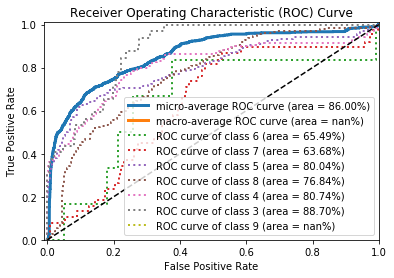

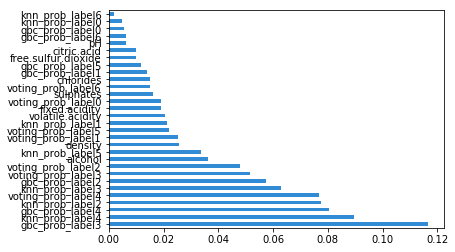

In [97]:
results = mm.get_results(GBM, 'LGBM', X_test, y_test['l'], gs = gs, target_names = [str(x) for x in y.unique()], target_labels = y.unique(), results=results, reasume=False)

In [98]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN
LinearSVC,True,0.6609,0.729357,NaN
RF,True,0.6555,0.721854,NaN
KNeighborsClassifier,True,0.6536,0.721447,NaN
LGBM,True,0.5882,0.700122,NaN


In [99]:
clf = Pipeline([
#     ('lda', LDA(store_covariance=True)),
    ('pca', PCA(random_state = 101)),
    ('clf', xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, n_jobs=1,
                       colsample_bytree=1, gamma=0.0001, max_delta_step=0, random_state=101, 
                       silent=True, subsample=1))])
n_est = [112] #112
max_depth = [15] 
learning_rate = [0.1] 
reg_lambda = [0.7] 
reg_alpha= [0.05]
booster = ['gbtree'] #  'dart'] #,'gblinear',
objective = ['multi:softmax'] #, 'multi:softprob']

param_grid =\
    [{ 
      'clf__n_estimators': n_est
      ,'clf__booster': booster
      ,'clf__objective': objective
      ,'clf__learning_rate': learning_rate
      ,'clf__reg_lambda': reg_lambda
      ,'clf__reg_alpha': reg_alpha
      ,'clf__max_depth': max_depth
#       ,'lda__n_components' : n_components
#     ,'pca__n_components' : n_components
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3,
                  verbose=1, n_jobs=3)

XGBC = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)), 
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [100]:
XGBC.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=3, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  59.09% 
Precision: 61.73% 
Recall:    59.09% 
F1 Score:  58.19% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.63      0.68      0.66       473
           7       0.83      0.38      0.52       200
           5       0.54      0.68      0.60       351
           8       0.34      0.34      0.34        32
           4       0.38      0.08      0.13        38
           3       0.09      0.17      0.12         6
           9       0.00      0.00      0.00         0

    accuracy                           0.59      1100
   macro avg       0.40      0.33      0.34      1100
weighted avg       0.62      0.59      0.58      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        323  10  122   9  2  6  1
        7         

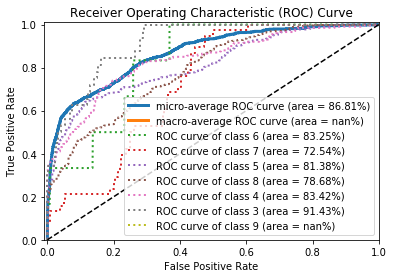

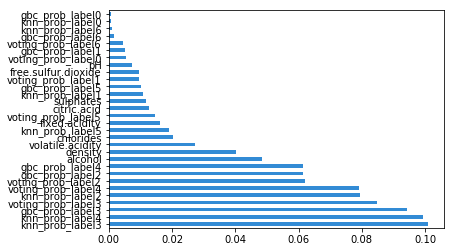

In [101]:
results = mm.get_results(XGBC, 'XGBC', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()], target_labels=y.unique(),results=results,reasume=False)

In [102]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN
LinearSVC,True,0.6609,0.729357,NaN
RF,True,0.6555,0.721854,NaN
KNeighborsClassifier,True,0.6536,0.721447,NaN
LGBM,True,0.5882,0.700122,NaN
XGBC,True,0.5909,0.684661,NaN


In [103]:
clf = Pipeline([
#     ('lda', LDA(store_covariance=True)),
    ('pca', PCA(random_state = 101)),
    ('clf', GradientBoostingClassifier(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
#cv=None, dual=False,  scoring=None, refit=True,  multi_class='ovr'
SEL = X_train.columns
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
# whiten = [True, False]
learning_rate =  [1e-02] #, 5e-03, 2e-02]
n_estimators= [400]
max_depth = [10]
n_comp = [2, 3, 4, 5]

param_grid =\
    [{'clf__learning_rate': learning_rate
     ,'clf__max_depth': max_depth
     ,'clf__n_estimators' : n_estimators 
#       ,'pca__n_components' : n_components
#      ,'lda__n_components' : n_components
     #,'pca__whiten' : whiten
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

GBC = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)),
        ('scl', StandardScaler()),
        ('gs', gs)
 ])  

In [104]:
GBC.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.9s finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  60.00% 
Precision: 66.62% 
Recall:    60.00% 
F1 Score:  57.81% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.58      0.79      0.67       473
           7       0.97      0.33      0.49       200
           5       0.56      0.58      0.57       351
           8       1.00      0.31      0.48        32
           4       1.00      0.08      0.15        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.60      0.60      0.60      1100
   macro avg       0.59      0.30      0.34      1100
weighted avg       0.67      0.60      0.58      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        376   2   95   0  0  0  0
        7         

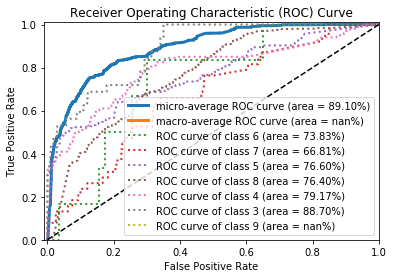

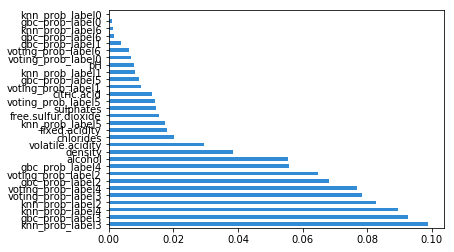

In [105]:
results = mm.get_results(GBC, 'GradientBoostingClassifier', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()]
                      ,target_labels=y.unique(), results=results, reasume=False)

In [106]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN
LinearSVC,True,0.6609,0.729357,NaN
RF,True,0.6555,0.721854,NaN
KNeighborsClassifier,True,0.6536,0.721447,NaN
LGBM,True,0.5882,0.700122,NaN
XGBC,True,0.5909,0.684661,NaN
GradientBoostingClassifier,True,0.6000,0.670792,NaN


In [107]:
clf = Pipeline([
#         ('lda', LDA(store_covariance=True)),
        ('pca', PCA(random_state = 101)),
        ('clf', AdaBoostClassifier(random_state=101))])

# a list of dictionaries to specify the parameters that we'd want to tune
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]

param_grid =\
    [{'clf__learning_rate': [2e-01, 15e-02]
     ,'clf__n_estimators': [500, 600, 700] 
     ,'clf__algorithm' : ['SAMME.R'] # 'SAMME'
     ,'pca__n_components' : n_components
     #,'pca__whiten' : whiten
#      ,'lda__n_components': n_components
#       ,'pca__n_components': n_components
     }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

ADAB = Pipeline([
        #('sel', select_fetaures(select_cols=SEL)),
        ('scl', StandardScaler()),
        #('lda', LDA(store_covariance=True)),
        ('gs', gs)
 ])  

In [108]:
ADAB.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.5min finished


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  57.18% 
Precision: 68.33% 
Recall:    57.18% 
F1 Score:  60.53% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.73      0.55      0.63       473
           7       0.76      0.41      0.53       200
           5       0.70      0.74      0.72       351
           8       0.12      0.72      0.21        32
           4       0.06      0.13      0.08        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.57      0.57      0.57      1100
   macro avg       0.34      0.36      0.31      1100
weighted avg       0.68      0.57      0.61      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                       
                   6   7    5   8   4  3  9
Actual: 6        261  14   81  77  40  0  0
        7      

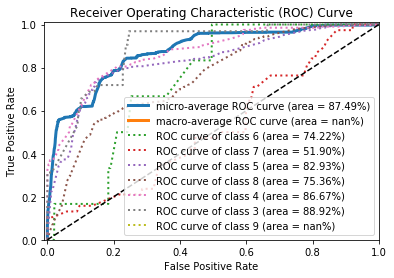

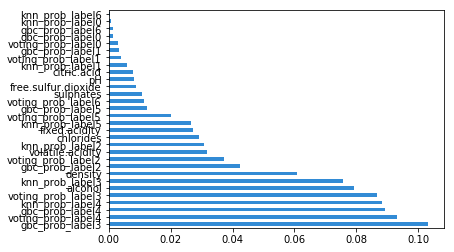

In [109]:
results = mm.get_results(ADAB, 'AdaBoostClassifier', X_test, y_test['l'], gs=gs, target_names=[str(x) for x in y.unique()]
                      ,target_labels=y.unique(), results=results, reasume=False)

In [110]:
results

,Prob,Accuracy,ROC AUC Score,ROC Area
LogisticRegression,True,0.6609,0.737153,NaN
DT First,True,0.6227,0.698525,NaN
LinearSVC,True,0.6609,0.729357,NaN
RF,True,0.6555,0.721854,NaN
KNeighborsClassifier,True,0.6536,0.721447,NaN
LGBM,True,0.5882,0.700122,NaN
XGBC,True,0.5909,0.684661,NaN
GradientBoostingClassifier,True,0.6000,0.670792,NaN
AdaBoostClassifier,True,0.5718,0.723659,NaN


In [111]:
estimators = [
    ('lr', LR),
    ('svc', svc)
    ]

In [112]:
voting = VotingClassifier(estimators,weights=[1.2, 1], voting='soft')

In [113]:
voting.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 603 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 1182 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.2s finished


VotingClassifier(estimators=[('lr',
                              Pipeline(memory=None,
                                       steps=[('scl',
                                               StandardScaler(copy=True,
                                                              with_mean=True,
                                                              with_std=True)),
                                              ('gs',
                                               GridSearchCV(cv=5,
                                                            error_score='raise-deprecating',
                                                            estimator=Pipeline(memory=None,
                                                                               steps=[('pca',
                                                                                       PCA(copy=True,
                                                                                           iterated_power='auto',
              

In [114]:
filename = '../model/add_proba_pca_rm_multico_voting_model.pickle'

In [232]:
with open(filename, mode='wb') as fp:
    pickle.dump(voting, fp, protocol=2)

Model Performance metrics:
------------------------------
Accuracy:  66.09% 
Precision: 67.69% 
Recall:    66.09% 
F1 Score:  64.26% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.63      0.77      0.69       473
           7       0.69      0.46      0.55       200
           5       0.69      0.74      0.71       351
           8       0.91      0.31      0.47        32
           4       1.00      0.05      0.10        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1100
   macro avg       0.56      0.33      0.36      1100
weighted avg       0.68      0.66      0.64      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        364  27   82   0  0  0  0
        7        1

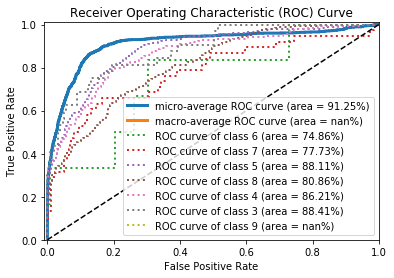

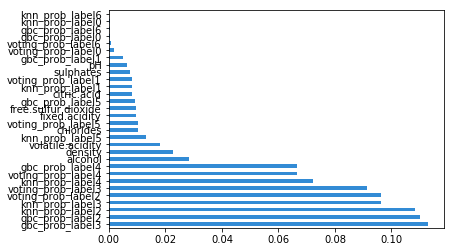

In [115]:
results = mm.get_results(voting, 'voting', X_test, y_test['l'], target_labels = y.unique(), target_names=[str(x) for x in y.unique()],results=results, reasume=False)

In [55]:
print(results)
results.to_csv('../data/add_proba_pca_rm_multico_results.csv')

                            Prob  Accuracy  ROC AUC Score  ROC Area
LogisticRegression          True    0.5136       0.593812       NaN
DT First                    True    0.5273       0.626935       NaN
LinearSVC                   True    0.5045       0.586540       NaN
RF                          True    0.6545       0.724859       NaN
KNeighborsClassifier        True    0.6555       0.724781       NaN
LGBM                        True    0.6409       0.717886       NaN
GradientBoostingClassifier  True    0.6564       0.728875       NaN
AdaBoostClassifier          True    0.2218       0.524381       NaN
voting                      True    0.6564       0.725725       NaN
